In [2]:
import rasterio
from rasterio.merge import merge
import glob
import os
import geopandas as gpd
import zipfile
# Define the path to your folder
data_directory = 'data/Topography_int16'

# --- AUTOMATIC STEP 1 ---
# This line finds all 20 .tif files and creates a list of their paths.
tif_files = glob.glob(os.path.join(data_directory, '*.tif'))

In [3]:
len(tif_files)

1239

In [4]:
#zip_path = 'map_data/cb_2024_us_county_20m.zip'
#zip_path = 'map_data/tl_2010_us_county10.zip'
zip_path = 'map_data/gz_2010_us_050_00_500k.zip'
extract_dir = 'map_data/temp'

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

# List files in the extracted directory to verify shapefile name
print('Extracted files:', os.listdir(extract_dir))

# Find the .shp file in the extracted directory
shp_files = [f for f in os.listdir(extract_dir) if f.endswith('.shp')]
if shp_files:
    shapefile_path = os.path.join(extract_dir, shp_files[0])
    gdf = gpd.read_file(shapefile_path)
    # Exclude Alaska (02), Hawaii (15), and Puerto Rico (72) using STATEFP column
    exclude_fips = ['02', '15', '72']
    gdf = gdf[~gdf['STATE'].isin(exclude_fips)]
    gdf['GEOID'] = gdf['GEO_ID'].str.split('US').str[1]
    print(gdf.head(2))
else:
    print('No .shp file found in extracted directory.')

Extracted files: ['gz_2010_us_050_00_500k.dbf', 'gz_2010_us_050_00_500k.prj', 'gz_2010_us_050_00_500k.shp', 'gz_2010_us_050_00_500k.shx', 'gz_2010_us_050_00_500k.xml']
           GEO_ID STATE COUNTY      NAME    LSAD  CENSUSAREA  \
0  0500000US01029    01    029  Cleburne  County     560.100   
1  0500000US01031    01    031    Coffee  County     678.972   

                                            geometry  GEOID  
0  POLYGON ((-85.38872 33.91304, -85.38088 33.873...  01029  
1  POLYGON ((-86.03044 31.61894, -86.00408 31.619...  01031  


In [5]:
gdf.reset_index(drop=True, inplace=True)

In [6]:
gdf = gdf.sort_values(by=['STATE', 'COUNTY']).reset_index(drop=True)

In [7]:
gdf

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,GEOID
0,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",01001
1,0500000US01003,01,003,Baldwin,County,1589.784,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",01003
2,0500000US01005,01,005,Barbour,County,884.876,"POLYGON ((-85.13285 31.80037, -85.13283 31.798...",01005
3,0500000US01007,01,007,Bibb,County,622.582,"POLYGON ((-87.11632 32.8356, -87.15529 32.8352...",01007
4,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.73121 34.0147, -86.7271 34.01691...",01009
...,...,...,...,...,...,...,...,...
3104,0500000US56037,56,037,Sweetwater,County,10426.649,"POLYGON ((-109.05008 41.00066, -109.17368 41.0...",56037
3105,0500000US56039,56,039,Teton,County,3995.379,"POLYGON ((-111.04668 43.8083, -111.04672 43.81...",56039
3106,0500000US56041,56,041,Uinta,County,2081.264,"POLYGON ((-110.04864 41.04008, -110.04848 40.9...",56041
3107,0500000US56043,56,043,Washakie,County,2238.549,"POLYGON ((-107.12892 43.99455, -107.12797 43.9...",56043


## Create Data

In [8]:
# Let's examine what we have in the directory first
print("=== DIAGNOSTIC: TIF FILES ANALYSIS ===")
print(f"Total TIF files found: {len(tif_files)}")

# Sample a few files to see what we're dealing with
sample_files = tif_files[:]
total_size = 0

for i, tif_file in enumerate(sample_files):
    try:
        size_mb = os.path.getsize(tif_file) / (1024**2)
        total_size += size_mb
        print(f"{i+1}. {os.path.basename(tif_file)}: {size_mb:.1f} MB")
        
        # Quick peek at the raster properties
        with rasterio.open(tif_file) as src:
            print(f"   Dimensions: {src.width} x {src.height}, Bands: {src.count}")
            print(f"   CRS: {src.crs}")
    except Exception as e:
        print(f"{i+1}. {os.path.basename(tif_file)}: Error reading - {e}")

if sample_files:
    avg_size = total_size / len(sample_files)
    estimated_total_gb = (avg_size * len(tif_files)) / 1024
    print(f"\nAverage file size: {avg_size:.1f} MB")
    print(f"Estimated total size: {estimated_total_gb:.1f} GB")
    print(f"Total size of sample files: {total_size:.1f} MB")
# Check if this might include duplicates or other files
unique_names = set(os.path.basename(f) for f in tif_files)
print(f"Unique filenames: {len(unique_names)}")
if len(unique_names) != len(tif_files):
    print("WARNING: Duplicate filenames detected!")

print("\nPress Enter to continue with compression...")

=== DIAGNOSTIC: TIF FILES ANALYSIS ===
Total TIF files found: 1239
1. compressed_USGS_13_n27w100_20240925.tif: 62.5 MB
   Dimensions: 10812 x 10812, Bands: 1
   CRS: EPSG:4269
2. compressed_USGS_13_n30w094_20240229.tif: 5.9 MB
   Dimensions: 10812 x 10812, Bands: 1
   CRS: EPSG:4269
3. compressed_USGS_1_n25w081_20220406.tif: 0.5 MB
   Dimensions: 3612 x 3612, Bands: 1
   CRS: EPSG:4269
4. compressed_USGS_1_n25w082_20220406.tif: 0.6 MB
   Dimensions: 3612 x 3612, Bands: 1
   CRS: EPSG:4269
5. compressed_USGS_1_n25w083_20220406.tif: 0.7 MB
   Dimensions: 3612 x 3612, Bands: 1
   CRS: EPSG:4269
6. compressed_USGS_1_n25w098_20130911.tif: 2.4 MB
   Dimensions: 3612 x 3612, Bands: 1
   CRS: EPSG:4269
7. compressed_USGS_1_n25w099_20130911.tif: 13.0 MB
   Dimensions: 3612 x 3612, Bands: 1
   CRS: EPSG:4269
8. compressed_USGS_1_n25w100_20130911.tif: 18.6 MB
   Dimensions: 3612 x 3612, Bands: 1
   CRS: EPSG:4269
9. compressed_USGS_1_n25w101_20130911.tif: 16.3 MB
   Dimensions: 3612 x 3612, Bands

In [9]:
print("Checking elevation data CRS...")
sample_tif = tif_files[0]
with rasterio.open(sample_tif) as src:
    elevation_crs = src.crs
    print(f"Elevation data CRS: {elevation_crs}")

print(f"County data CRS: {gdf.crs}")

# Reproject counties to match elevation data
if gdf.crs != elevation_crs:
    gdf_reprojected = gdf.to_crs(elevation_crs)
    print(f"Reprojected counties to: {gdf_reprojected.crs}")
else:
    gdf_reprojected = gdf.copy()
    print("CRS already match")

print(f"Processing {len(gdf_reprojected)} counties")

Checking elevation data CRS...
Elevation data CRS: EPSG:4269
County data CRS: EPSG:4269
CRS already match
Processing 3109 counties


In [10]:
import rasterio
from rasterstats import zonal_stats
import glob
import os
import subprocess
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import time

# --- Assume gdf_reprojected is already loaded ---
# Example placeholder - replace with your actual data loading
# shp_path = "path/to/your/counties.shp"
# gdf = gpd.read_file(shp_path)
# gdf_reprojected = gdf.to_crs("EPSG:YOUR_RASTER_CRS") # Ensure CRS matches raster

# --- Script Start ---
tif_files = glob.glob("data/Topography_int16/*.tif")
print(f"Found {len(tif_files)} files to process.")
vrt_path = "temp_elevation.vrt"

try:
    # 1. CREATE FILE LIST
    file_list_path = "temp_file_list.txt"
    print(f"✅ Step 1/5: Creating temporary file list at: {file_list_path}")
    with open(file_list_path, "w") as f:
        for tif_file in tif_files:
            f.write(f"{tif_file}\n")

    # 2. BUILD AND RUN GDAL COMMAND
    cmd = ["gdalbuildvrt", "-input_file_list", file_list_path, vrt_path]
    print("⏳ Step 2/5: Building virtual raster (VRT)... (this may take a moment)")
    
    start_time = time.time()
    result = subprocess.run(cmd, capture_output=True, text=True, timeout=600)
    end_time = time.time()
    
    os.remove(file_list_path)

    # 3. CHECK FOR GDAL ERRORS
    print("🔎 Step 3/5: Verifying GDAL output...")
    if result.returncode != 0:
        print("--- GDAL Error ---")
        print(result.stderr)
        raise Exception("gdalbuildvrt failed.")
    
    print(f"✅ VRT created successfully in {end_time - start_time:.2f} seconds.")

    # 4. CALCULATE ZONAL STATISTICS
    print("📊 Step 4/5: Calculating elevation statistics for each county...")
    # The zonal_stats function returns a list of dictionaries
    stats_list = zonal_stats(
        gdf_reprojected,
        vrt_path,
        stats=["min", "max", "mean", "median", "std", "count"],
        nodata=-9999,
        geojson_out=False # Keep output as a simple list of dicts
    )
    
    # 5. MERGE STATISTICS BACK TO GEODATAFRAME
    print("🔗 Step 5/5: Merging statistics with county GeoDataFrame...")
    
    # Convert the list of dictionaries into a Pandas DataFrame
    stats_df = pd.DataFrame(stats_list)
    
    # Rename columns for clarity (optional but recommended)
    stats_df.rename(columns={
        'min': 'min_elevation',
        'max': 'max_elevation',
        'mean': 'mean_elevation',
        'median': 'median_elevation',
        'std': 'std_elevation',
        'count': 'pixel_count'
    }, inplace=True)

    # Join the new statistics DataFrame with the original GeoDataFrame
    # This works because the order of the results matches the order of the input geometries
    county_level_stats_gdf = gdf_reprojected.join(stats_df)

    print("\n🎉 Success! County-level statistics generated.")
    print("Final GeoDataFrame head:")
    print(county_level_stats_gdf.head())


finally:
    if os.path.exists(vrt_path):
        os.remove(vrt_path)
        print(f"\n🧹 Cleaned up temporary file: {vrt_path}")

Found 1239 files to process.
✅ Step 1/5: Creating temporary file list at: temp_file_list.txt
⏳ Step 2/5: Building virtual raster (VRT)... (this may take a moment)
🔎 Step 3/5: Verifying GDAL output...
✅ VRT created successfully in 3.11 seconds.
📊 Step 4/5: Calculating elevation statistics for each county...
🔗 Step 5/5: Merging statistics with county GeoDataFrame...

🎉 Success! County-level statistics generated.
Final GeoDataFrame head:
           GEO_ID STATE COUNTY     NAME    LSAD  CENSUSAREA  \
0  0500000US01001    01    001  Autauga  County     594.436   
1  0500000US01003    01    003  Baldwin  County    1589.784   
2  0500000US01005    01    005  Barbour  County     884.876   
3  0500000US01007    01    007     Bibb  County     622.582   
4  0500000US01009    01    009   Blount  County     644.776   

                                            geometry  GEOID  min_elevation  \
0  POLYGON ((-86.52469 32.70706, -86.52443 32.707...  01001           25.0   
1  POLYGON ((-87.41247 30.

In [16]:
stats_df = pd.DataFrame(stats_list)
    
    # Rename columns for clarity (optional but recommended)
stats_df.rename(columns={
    'min': 'min_elevation',
    'max': 'max_elevation',
    'mean': 'mean_elevation',
    'median': 'median_elevation',
    'std': 'std_elevation',
    'count': 'pixel_count'
}, inplace=True)

    # Join the new statistics DataFrame with the original GeoDataFrame
    # This works because the order of the results matches the order of the input geometries




In [17]:
stats_df.tail(3200)

,min_elevation,max_elevation,mean_elevation,pixel_count,std_elevation,median_elevation
0,25.0,231.0,107.561017,1951644,39.927629,110.0
1,-1.0,99.0,29.068636,5322483,22.894482,27.0
2,57.0,211.0,114.419581,2899855,28.876441,114.0
3,49.0,231.0,124.258423,2032790,31.072710,126.0
4,82.0,470.0,239.952370,2135364,63.483737,242.0
...,...,...,...,...,...,...
3104,1838.0,2913.0,2091.654945,38146981,120.600584,2075.0
3105,1765.0,4184.0,2453.549162,15899852,292.888525,2444.0
3106,1918.0,2983.0,2210.108819,7549515,200.696799,2173.0
3107,1202.0,2923.0,1594.567752,8451896,341.674074,1462.0


In [18]:
county_level_stats_gdf = gdf_reprojected.join(stats_df)

In [19]:
gdf_reprojected

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,GEOID
0,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",01001
1,0500000US01003,01,003,Baldwin,County,1589.784,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",01003
2,0500000US01005,01,005,Barbour,County,884.876,"POLYGON ((-85.13285 31.80037, -85.13283 31.798...",01005
3,0500000US01007,01,007,Bibb,County,622.582,"POLYGON ((-87.11632 32.8356, -87.15529 32.8352...",01007
4,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.73121 34.0147, -86.7271 34.01691...",01009
...,...,...,...,...,...,...,...,...
3104,0500000US56037,56,037,Sweetwater,County,10426.649,"POLYGON ((-109.05008 41.00066, -109.17368 41.0...",56037
3105,0500000US56039,56,039,Teton,County,3995.379,"POLYGON ((-111.04668 43.8083, -111.04672 43.81...",56039
3106,0500000US56041,56,041,Uinta,County,2081.264,"POLYGON ((-110.04864 41.04008, -110.04848 40.9...",56041
3107,0500000US56043,56,043,Washakie,County,2238.549,"POLYGON ((-107.12892 43.99455, -107.12797 43.9...",56043


In [20]:
county_level_stats_gdf.iloc[250:].head(3000)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,GEOID,min_elevation,max_elevation,mean_elevation,pixel_count,std_elevation,median_elevation
250,0500000US08069,08,069,Larimer,County,2596.002,"POLYGON ((-106.19055 40.99761, -106.06118 40.9...",08069,1455.0,4130.0,2361.225831,9434252,578.010536,2382.0
251,0500000US08071,08,071,Las Animas,County,4772.672,"POLYGON ((-104.48045 36.99372, -104.51926 36.9...",08071,1317.0,4133.0,1830.189930,16327019,357.941850,1723.0
252,0500000US08073,08,073,Lincoln,County,2577.626,"POLYGON ((-103.71494 39.26751, -103.71494 39.2...",08073,1347.0,1818.0,1564.941821,9043762,86.455498,1570.0
253,0500000US08075,08,075,Logan,County,1838.547,"POLYGON ((-102.90487 41.00221, -102.9048 41.00...",08075,1108.0,1505.0,1277.895914,6615137,67.094897,1280.0
254,0500000US08077,08,077,Mesa,County,3328.974,"POLYGON ((-109.05157 39.11771, -109.05151 39.1...",08077,1320.0,3424.0,2092.705865,11691298,494.882337,2046.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,0500000US56037,56,037,Sweetwater,County,10426.649,"POLYGON ((-109.05008 41.00066, -109.17368 41.0...",56037,1838.0,2913.0,2091.654945,38146981,120.600584,2075.0
3105,0500000US56039,56,039,Teton,County,3995.379,"POLYGON ((-111.04668 43.8083, -111.04672 43.81...",56039,1765.0,4184.0,2453.549162,15899852,292.888525,2444.0
3106,0500000US56041,56,041,Uinta,County,2081.264,"POLYGON ((-110.04864 41.04008, -110.04848 40.9...",56041,1918.0,2983.0,2210.108819,7549515,200.696799,2173.0
3107,0500000US56043,56,043,Washakie,County,2238.549,"POLYGON ((-107.12892 43.99455, -107.12797 43.9...",56043,1202.0,2923.0,1594.567752,8451896,341.674074,1462.0


In [22]:
import matplotlib.pyplot as plt

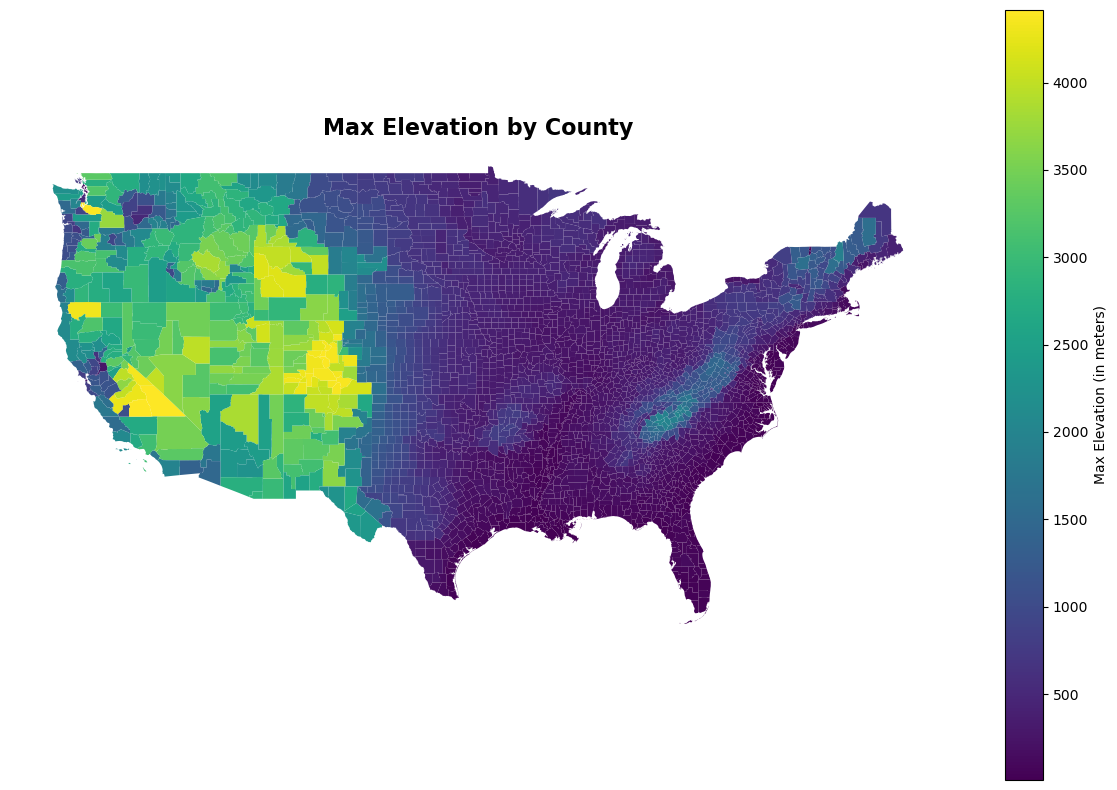

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
county_level_stats_gdf.plot(
    column='max_elevation',
    cmap='viridis',
    legend=True,
    legend_kwds={
        'label': "Max Elevation (in meters)",
        'orientation': "vertical"
    },
    ax=ax
    )
ax.set_title('Max Elevation by County', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [26]:
# Convert county_level_stats_gdf to a pandas DataFrame (drop geometry column)
import pandas as pd
df = pd.DataFrame(county_level_stats_gdf.drop(columns='geometry'))
df.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,GEOID,min_elevation,max_elevation,mean_elevation,pixel_count,std_elevation,median_elevation
0,0500000US01001,01,001,Autauga,County,594.436,01001,25.0,231.0,107.561017,1951644,39.927629,110.0
1,0500000US01003,01,003,Baldwin,County,1589.784,01003,-1.0,99.0,29.068636,5322483,22.894482,27.0
2,0500000US01005,01,005,Barbour,County,884.876,01005,57.0,211.0,114.419581,2899855,28.876441,114.0
3,0500000US01007,01,007,Bibb,County,622.582,01007,49.0,231.0,124.258423,2032790,31.072710,126.0
4,0500000US01009,01,009,Blount,County,644.776,01009,82.0,470.0,239.952370,2135364,63.483737,242.0


In [27]:
df.to_csv("data_processed/node_feat/elevation_data.csv", index=False)

In [38]:
county_level_stats_gdf.to_file("data_processed/node_feat/elevation_data_geo.gpkg", driver="GPKG")

## Run

In [28]:
Elevation = pd.read_csv("data_processed/node_feat/elevation_data.csv")

In [39]:
import geopandas as gpd
Elevation_geo = gpd.read_file("data_processed/node_feat/elevation_data_geo.gpkg", driver="GPKG")


c:\Users\naoki\miniforge3\envs\gnn-env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


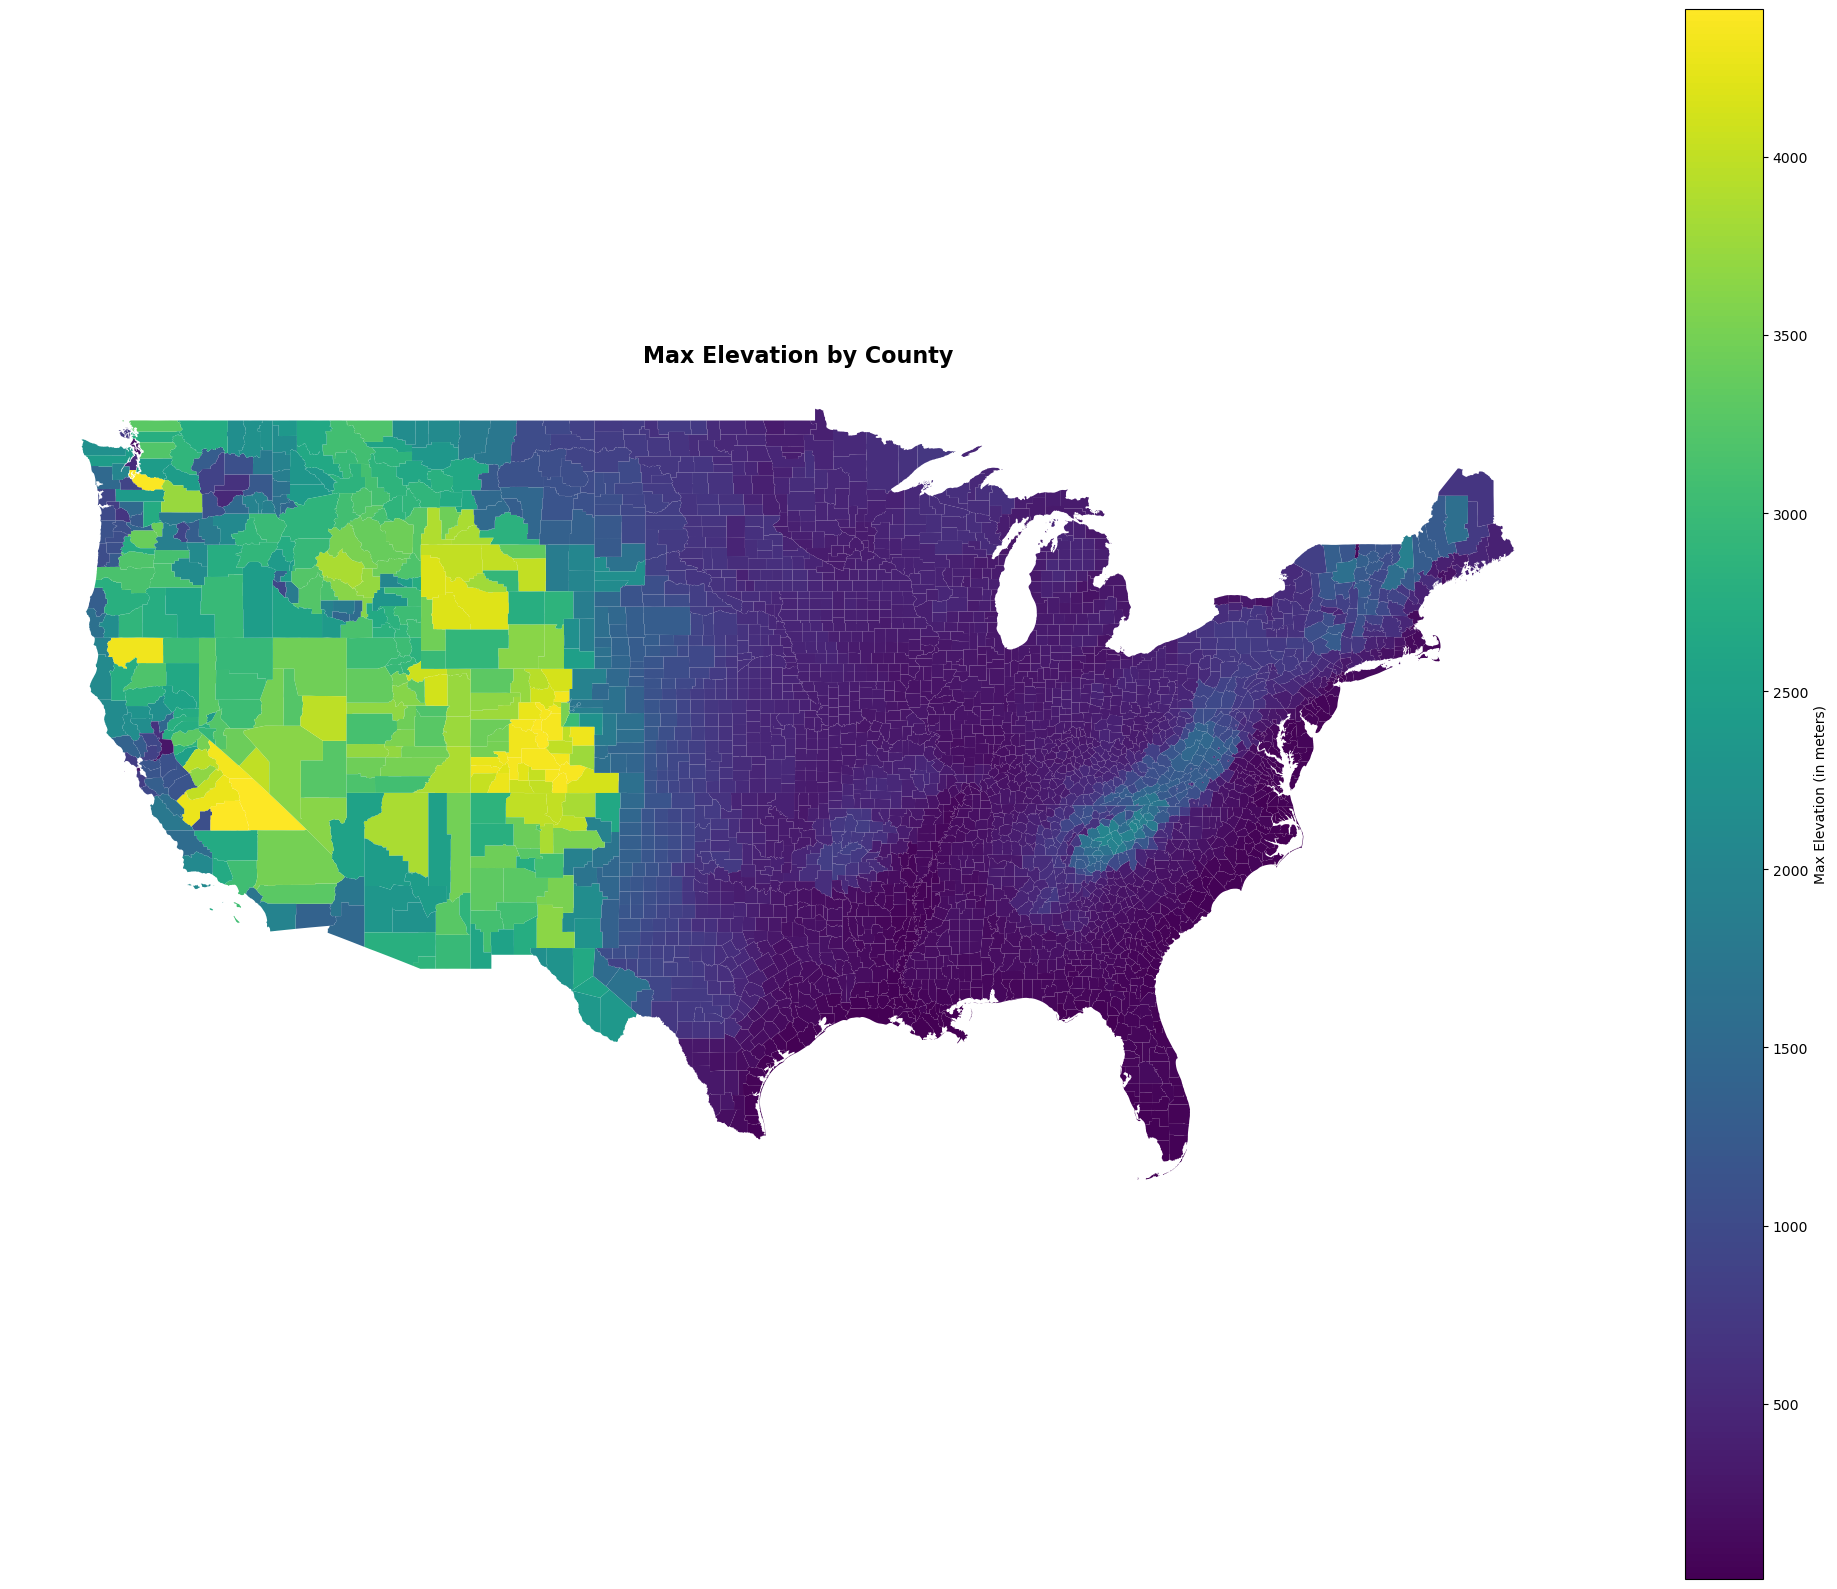

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
Elevation_geo.plot(
    column='max_elevation',
    cmap='viridis',
    legend=True,
    legend_kwds={
        'label': "Max Elevation (in meters)",
        'orientation': "vertical"
    },
    ax=ax
    )
ax.set_title('Max Elevation by County', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_axis_off()
plt.tight_layout()
plt.show()